# RECONOCIMIENTO FACIAL

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Carpetas en D:/taller/dataset/: ['001_kev', '002_luis', '003_christian', '004_franklin']


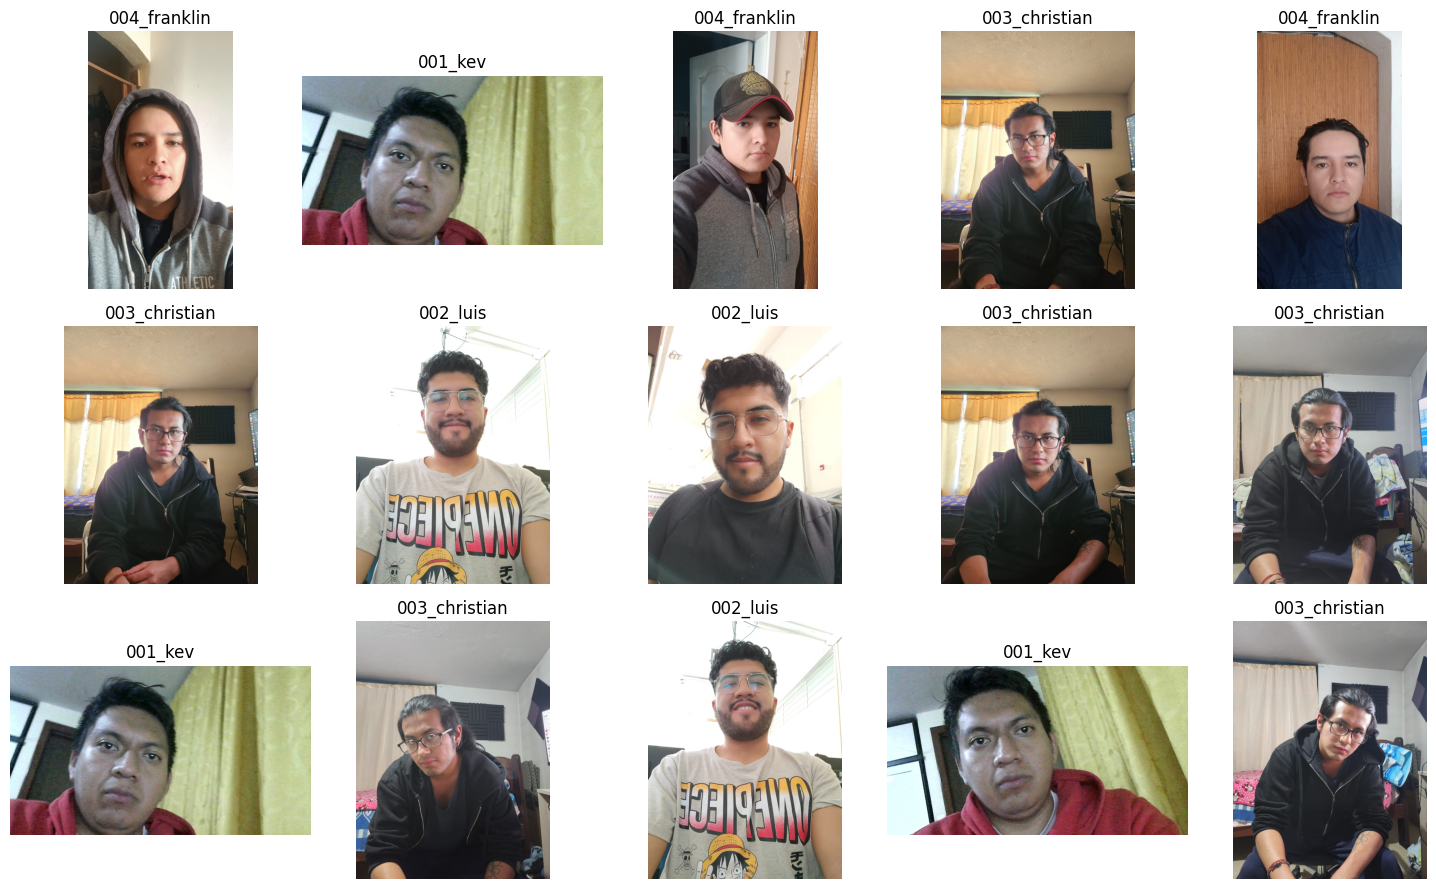

In [2]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Rutas de los datos
fotos_mias = "D:/taller/dataset/"  # Tus fotos
if not os.path.exists(fotos_mias):
    print(f"⚠️ Error: La carpeta '{fotos_mias}' no existe.")
else:
    fotos_mias_folders = os.listdir(fotos_mias)
    print(f"Carpetas en {fotos_mias}: {fotos_mias_folders}")


# Listado de carpetas en fotos_mias (asumimos que cada carpeta es una persona)
fotos_mias_folders = os.listdir(fotos_mias)


# Seleccionar 15 imágenes aleatorias
total_images = 15
selected_images = []

# Seleccionar imágenes de fotos_mias
for folder in fotos_mias_folders:
    folder_path = os.path.join(fotos_mias, folder)
    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)
        for img in images:
            selected_images.append((os.path.join(folder_path, img), folder))

if len(selected_images) < total_images:
    print(f"⚠️ Advertencia: Solo hay {len(selected_images)} imágenes disponibles, no {total_images}. Se usarán todas las disponibles.")
    total_images = len(selected_images)  # Ajustar total_images a la cantidad real disponible

selected_images = random.sample(selected_images, total_images)
# Seleccionar 15 imágenes aleatorias
selected_images = random.sample(selected_images, total_images)

# Plotear las imágenes
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.flatten()

for (img_path, label), ax in zip(selected_images, axes):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [4]:
import os
import numpy as np

# Listas para los archivos y las etiquetas
fotos_mias_files = []
fotos_mias_attri = []

# Asignar una etiqueta única a cada persona basada en el valor numérico de la carpeta
for folder in fotos_mias_folders:
    folder_path = os.path.join(fotos_mias, folder)
    if os.path.isdir(folder_path):
        # Extraer el número del nombre de la carpeta (asumiendo formato 001_Nombre)
        folder_number = int(folder.split('_')[0])
        
        # Listar todas las imágenes dentro de la subcarpeta
        files_in_folder = os.listdir(folder_path)
        for file in files_in_folder:
            fotos_mias_files.append(os.path.join(fotos_mias, folder, file))  # Ruta completa de la imagen
            fotos_mias_attri.append(folder_number)  # Asignar una etiqueta basada en el número de la carpeta

fotos_mias_files = np.array(fotos_mias_files)
fotos_mias_attri = np.array(fotos_mias_attri)


# Imprimir los arrays generados
print("fotos_mias_files_array:")
print(fotos_mias_files)

print("\nfotos_mias_attri_array:")
print(fotos_mias_attri)

fotos_mias_files_array:
['D:/taller/dataset/001_kev\\0016_kev.jpg'
 'D:/taller/dataset/001_kev\\001_kev.jpg'
 'D:/taller/dataset/001_kev\\002_kev.jpg'
 'D:/taller/dataset/001_kev\\003_kev.jpg'
 'D:/taller/dataset/001_kev\\004_kev.jpg'
 'D:/taller/dataset/001_kev\\005_kev.jpg'
 'D:/taller/dataset/001_kev\\006_kev.jpg'
 'D:/taller/dataset/001_kev\\007_kev.jpg'
 'D:/taller/dataset/001_kev\\008_kev.jpg'
 'D:/taller/dataset/001_kev\\009_kev.jpg'
 'D:/taller/dataset/001_kev\\010_kev.jpg'
 'D:/taller/dataset/001_kev\\011_kev.jpg'
 'D:/taller/dataset/001_kev\\012_kev.jpg'
 'D:/taller/dataset/001_kev\\013_kev.jpg'
 'D:/taller/dataset/001_kev\\015_kev.jpg'
 'D:/taller/dataset/001_kev\\044_kev.jpg'
 'D:/taller/dataset/002_luis\\001_luis.jpg'
 'D:/taller/dataset/002_luis\\002_luis.jpg'
 'D:/taller/dataset/002_luis\\003_luis.jpg'
 'D:/taller/dataset/002_luis\\004_luis.jpg'
 'D:/taller/dataset/002_luis\\005_luis.jpg'
 'D:/taller/dataset/002_luis\\006_luis.jpg'
 'D:/taller/dataset/002_luis\\007_luis.

In [5]:
import keras
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Dropout,Activation,MaxPooling2D,Flatten
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf


import matplotlib.pyplot as plt
import numpy as np

ih = 128
iw = 128

percent = 0.15

BATCH_SIZE = 32
epochs = 20

N_d = 100

STEPS_PER_EPOCH =  int(((len(fotos_mias_folders)+1)*N_d*(1-percent)) // BATCH_SIZE)
VALIDATION_STEPS = int(((len(fotos_mias_folders)+1)*N_d * percent) // BATCH_SIZE)
#==============================================================================
#                               procesamiento de Datos


fotos_mias_files = tf.data.Dataset.from_tensor_slices(fotos_mias_files)
fotos_mias_attri = tf.data.Dataset.from_tensor_slices(fotos_mias_attri)

fotos_mias_data = tf.data.Dataset.zip((fotos_mias_files,fotos_mias_attri))


def process_file_fotos_mias(file_name, fotos_mias_attri):
    print(fotos_mias)
    image = tf.io.read_file(file_name)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [ih,iw])
    image /= 255.0
    return image, fotos_mias_attri

labeled_images_fotos_mias = fotos_mias_data.map(process_file_fotos_mias)

labeled_images = labeled_images_fotos_mias
labeled_images = labeled_images.shuffle((len(fotos_mias_folders)+1)*N_d)

print('=======================================================================')

print('labeled_images:')
print(labeled_images)
print('labeled_images_len:')
print(len(labeled_images))

print('=======================================================================')

dataset_size = int(N_d* (len(fotos_mias_folders)+1)* (1-percent))

training_data = labeled_images.take(dataset_size)
training_data = training_data.repeat().batch(BATCH_SIZE)

test_data = labeled_images.skip(dataset_size)
test_data = test_data.repeat().batch(BATCH_SIZE)

print('=======================================================================')
print('split dataset in training and test data')

print('training_data')
print(training_data)

print('test_data')
print(test_data)

print('=======================================================================')
#==============================================================================

D:/taller/dataset/
labeled_images:
<_ShuffleDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
labeled_images_len:
68
split dataset in training and test data
training_data
<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
test_data
<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [6]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import datetime

# Número de clases (usuarios)
num_classes = len (fotos_mias_folders) +1  # Ajusta esto al número de usuarios en tu conjunto de datos

# Cargar el modelo preentrenado
pre_trained_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Crear un nuevo modelo
model = Sequential()

# Añadir las capas preentrenadas al nuevo modelo
for layer in pre_trained_model.layers:
    model.add(layer)

# Añadir nuevas capas al modelo
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation="softmax"))  # Cambiar a softmax para múltiples clases

# Congelar las capas preentrenadas
for layer in model.layers[:-4]:  # Congelar todas las capas excepto las últimas 4
    layer.trainable = False

# Compilar el modelo
model.compile(loss="sparse_categorical_crossentropy",  # Cambiar a sparse_categorical_crossentropy
              optimizer=Adam(),
              metrics=["accuracy"])

model.summary()

# Configurar TensorBoard
log_dir = "redes_entrenadas/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Entrenar el modelo
history = model.fit(
    training_data,
    epochs=epochs,
    steps_per_epoch=STEPS_PER_EPOCH,
    batch_size=BATCH_SIZE,
    validation_data=test_data,
    validation_steps=VALIDATION_STEPS,
    callbacks=[tensorboard_callback]
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,771,973 (60.17 MB)

 Trainable params: 1,057,285 (4.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.5115 - loss: 1.2897

C:\Users\pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 680ms/step - accuracy: 0.5303 - loss: 1.2433
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 657ms/step - accuracy: 0.9990 - loss: 0.0261
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 637ms/step - accuracy: 1.0000 - loss: 0.0029
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 636ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 672ms/step - accuracy: 1.0000 - loss: 0.0022
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 663ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 692ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 697ms/step - accuracy: 1.0000 - loss: 7.1832e-04
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 729ms/step - accuracy: 1.0000 - loss: 6.7975e-04
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 747ms/step - accuracy: 1.0000 - loss: 4.0215e-04
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 696ms/step - accuracy: 1.0000 - loss: 5.1152e-04
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 688

In [8]:
pip install seaborn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Carpetas en el directorio de imágenes:
['001_kev', '002_luis', '003_christian', '004_franklin']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Usuario: kev, Confianza: 99.10%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Usuario: luis, Confianza: 94.66%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Usuario: luis, Confianza: 95.07%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Usuario: luis, Confianza: 91.59%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Usuario: luis, Confianza: 95.38%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Usuario: luis, Confianza: 95.29%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Usuario: luis, Confianza: 96.28%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Usuario: luis, Confianza: 93.06%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Usuario: luis, Confianza: 89.11%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Usuario: luis, Confianza: 89.29%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Usuario: luis, Confianza: 99.11%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Usuario: luis, Confianza: 98.93%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Usuario: luis, Confianza: 99.60%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Usuario: luis, Confianza: 96.31%
1/1 ━━

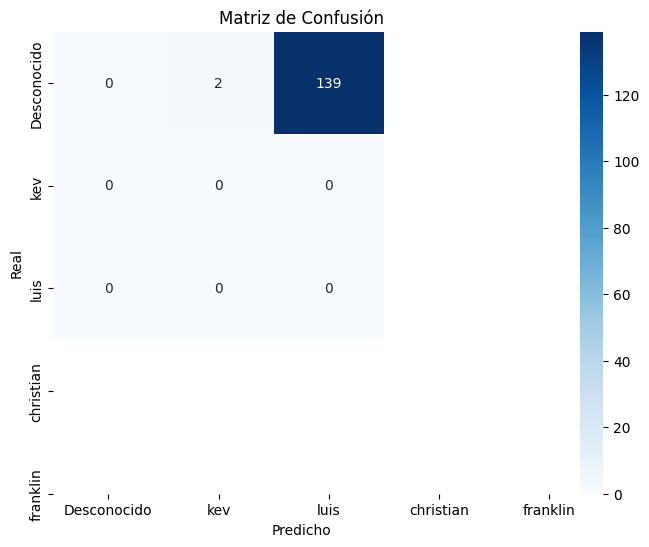

In [7]:
import cv2
import os
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

padding = 100

# Directorio de las imágenes
image_dir = 'D:/taller/dataset'

print("Carpetas en el directorio de imágenes:")
print(os.listdir(image_dir))  # Esto mostrará todas las carpetas encontradas

# Crear un diccionario que mapea la clase 0 a "Desconocido"
class_to_name = {0: 'Desconocido'}

# Agregar las demás clases automáticamente, ignorando archivos y asegurando que tienen formato correcto
for idx, folder_name in enumerate(os.listdir(image_dir), start=1):
    folder_path = os.path.join(image_dir, folder_name)
    
    if os.path.isdir(folder_path):  # Solo procesar carpetas
        partes = folder_name.split('_')
        if len(partes) > 1 and partes[0].isdigit():
            user_name = partes[1]
        else:
            print(f"⚠️ Advertencia: La carpeta '{folder_name}' no tiene el formato correcto y se ignorará.")
            user_name = "Desconocido"
        class_to_name[idx] = user_name

# Cargar el modelo de predicción
model_facial = load_model('redes_entrenadas/ReconocimientoFacialV02.h5')

# Inicializar MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Inicializar la captura de video
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1080)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
cap.set(cv2.CAP_PROP_FPS, 60)

if not cap.isOpened():
    print("Error: No se pudo abrir la cámara.")
    exit()

# Listas para la matriz de confusión
y_true = []  # Etiquetas reales
y_pred = []  # Etiquetas predichas

def reconocer_rostro(face, clase_real):
    try:
        face_resized = cv2.resize(face, (128, 128))
        face_resized = face_resized.astype('float32') / 255.0 
        face_resized = np.expand_dims(face_resized, axis=0)

        usuario = model_facial.predict(face_resized)
        probabilidad = np.max(usuario) * 100
        clase_predicha = np.argmax(usuario, axis=1)[0]

        user_name = class_to_name.get(clase_predicha, "Desconocido")
        if probabilidad < 70:
            user_name = "Desconocido"
            probabilidad = 0

        print(f"Usuario: {user_name}, Confianza: {probabilidad:.2f}%")
        
        # Agregar datos a la matriz de confusión
        y_true.append(clase_real)
        y_pred.append(clase_predicha)

        return user_name, probabilidad, clase_predicha
    except Exception as e:
        print(f"Error al predecir el modelo: {e}")
        return "Desconocido", 0, -1

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: No se pudo leer el fotograma.")
        break

    frame = cv2.flip(frame, 1)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_frame)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            ih, iw, _ = frame.shape
            x_min = iw
            y_min = ih
            x_max = 0
            y_max = 0

            for landmark in face_landmarks.landmark:
                x, y = int(landmark.x * iw), int(landmark.y * ih)
                x_min = min(x_min, x)
                y_min = min(y_min, y)
                x_max = max(x_max, x)
                y_max = max(y_max, y)

            x, y, w, h = x_min, y_min, x_max - x_min, y_max - y_min
            x_centered = max(0, x - padding)
            y_centered = max(0, y - 2 * padding)
            w_centered = min(iw, x + w + padding) - x_centered
            h_centered = min(ih, y + h + 2 * padding) - y_centered

            face = frame[y_centered:y_centered + h_centered, x_centered:x_centered + w_centered]
            if face.size > 0:
                clase_real = 0  # Asignar etiqueta real (modificar según sea necesario)
                nombre, confianza, clase_predicha = reconocer_rostro(face, clase_real)
                confianza = round(confianza, 3)

            cv2.putText(frame, f"Usuario: {nombre} ({confianza}%) Clase: {clase_predicha}", (x, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)

    cv2.imshow('Reconocimiento Facial', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Generar y mostrar la matriz de confusión
y_true = np.array(y_true)
y_pred = np.array(y_pred)

if len(y_true) > 0:
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_to_name.values(), yticklabels=class_to_name.values())
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()
else:
    print("⚠️ No se recopilaron datos suficientes para generar la matriz de confusión.")


In [22]:
# Sobrescribir los archivos existentes al guardar los pesos y el modelo
model.save("redes_entrenadas/ReconocimientoFacialV02.h5")

In [23]:
# Para visualizar los resultados de TensorBoard
%load_ext tensorboard
%tensorboard --logdir logs/fit